In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import kagglehub
from pathlib import Path

In [11]:
# Download latest version
path = Path(kagglehub.dataset_download("sandersekreve/bitcoin-dataset-2018-2025"))

In [12]:
csv_path = path / 'bitcoin_prices_fear_greed_full.csv'
df = pd.read_csv(csv_path)


In [13]:
df.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,fear_greed
0,01/01/2018,13715.65,13818.55,12750.00,13380.00,8609.915844,00:00.0,114799747.4,105595,3961.938946,5.280975e+07,0,47.0
1,02/01/2018,13382.16,15473.49,12890.02,14675.11,20078.092110,00:00.0,279717107.4,177728,11346.326740,1.580801e+08,0,47.0
2,03/01/2018,14690.00,15307.56,14150.00,14919.51,15905.667640,00:00.0,236116868.3,162787,8994.953566,1.335873e+08,0,47.0
3,04/01/2018,14919.51,15280.00,13918.04,15059.54,21329.649570,00:00.0,312781583.8,170310,12680.812950,1.861168e+08,0,47.0
4,05/01/2018,15059.56,17176.24,14600.00,16960.39,23251.491130,00:00.0,369321956.5,192969,13346.622290,2.118299e+08,0,47.0


In [14]:
# Fill 'fear_greed' NaN values with the average of all values in that column
df['fear_greed'].fillna(df['fear_greed'].mean().round(), inplace=True)

C:\Users\sande\AppData\Local\Temp\ipykernel_15728\3498500974.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['fear_greed'].fillna(df['fear_greed'].mean().round(), inplace=True)


In [15]:
# Add technical indicators

# Simple Moving Averages
df["SMA_7"] = df["Close"].rolling(window=7).mean()
df["SMA_21"] = df["Close"].rolling(window=21).mean()

# RSI (Relative Strength Index)
delta = df["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df["RSI_14"] = 100 - (100 / (1 + rs))

# MACD (Moving Average Convergence Divergence)
exp1 = df["Close"].ewm(span=12, adjust=False).mean()
exp2 = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = exp1 - exp2
df["Signal_line"] = df["MACD"].ewm(span=9, adjust=False).mean()

df.dropna(inplace=True)

In [ ]:
# === Feature Selection ===
features = [
    # 'Open', 'High', 'Low', 'Close', 'Volume', 'fear_greed',
    # MACD, Signal_line, SMA_7, RSI_14
    'High', 'Low', 'Close', 'SMA_21'
]
target_col = "High"
target_idx = features.index(target_col)

data = df[features]


corr_matrix = df[features].corr()
print(corr_matrix)


            High       Low     Close    SMA_21
High    1.000000  0.998882  0.999507  0.993396
Low     0.998882  1.000000  0.999377  0.992902
Close   0.999507  0.999377  1.000000  0.992888
SMA_21  0.993396  0.992902  0.992888  1.000000


In [17]:
# === Train/Test Split ===
sequence_length = 30
split_idx = int(len(data) * 0.8)

train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

In [18]:
# === Scaling ===
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [19]:
# === Build Sequences ===
def build_sequences(scaled_data):
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, target_idx])
    return np.array(X), np.array(y)

X_train, y_train = build_sequences(train_scaled)
X_test, y_test = build_sequences(test_scaled)

In [20]:
# === Model Definition ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

d:\VSCODE_PROJECTS\btc-predictor\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0101 - val_loss: 5.7809e-04
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025 - val_loss: 5.8054e-04
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0024 - val_loss: 5.9630e-04
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0018 - val_loss: 7.9489e-04
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021 - val_loss: 4.0014e-04
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0017 - val_loss: 3.7669e-04
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_loss: 8.5263e-04
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0017 - val_loss: 4.0918e-04
Epoch 9/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014 - val_loss: 7.4566e-04
Epoch 10/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016 - val_loss: 3.4096e-04
Epoch 11/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016 - val_loss: 6.8796e-04
Epoch 12/25
59/59 ━

In [21]:
# === Prediction ===
predicted_scaled = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [22]:
# === Invert Scaling for Target ===
high_mean = scaler.data_min_[target_idx]
high_scale = scaler.data_max_[target_idx] - scaler.data_min_[target_idx]

predicted_high = predicted_scaled * high_scale + high_mean
actual_high = y_test * high_scale + high_mean

In [23]:

# === Evaluation ===
mae = mean_absolute_error(actual_high, predicted_high)
rmse = np.sqrt(mean_squared_error(actual_high, predicted_high))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10  # to avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

mape = mean_absolute_percentage_error(actual_high, predicted_high)

print(f"📏 MAE: ${mae:.2f}")
print(f"📏 RMSE: ${rmse:.2f}")
print(f"📉 MAPE: {mape:.2f}%")

📏 MAE: $2186.99
📏 RMSE: $2936.36
📉 MAPE: 28.64%


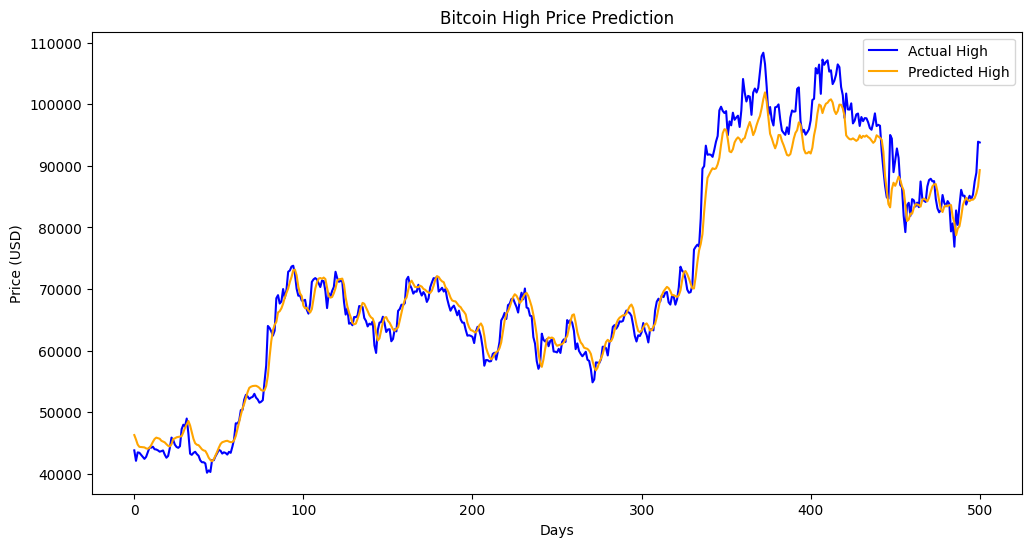

In [24]:
# === (Optional) Plotting ===
plt.figure(figsize=(12, 6))
plt.plot(actual_high, label="Actual High", color="blue")
plt.plot(predicted_high, label="Predicted High", color="orange")
plt.title("Bitcoin High Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

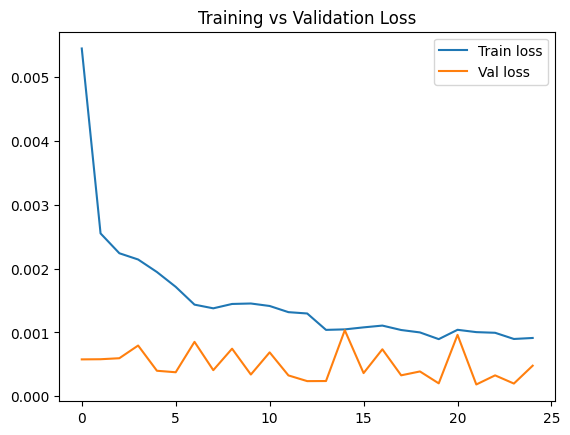

In [25]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


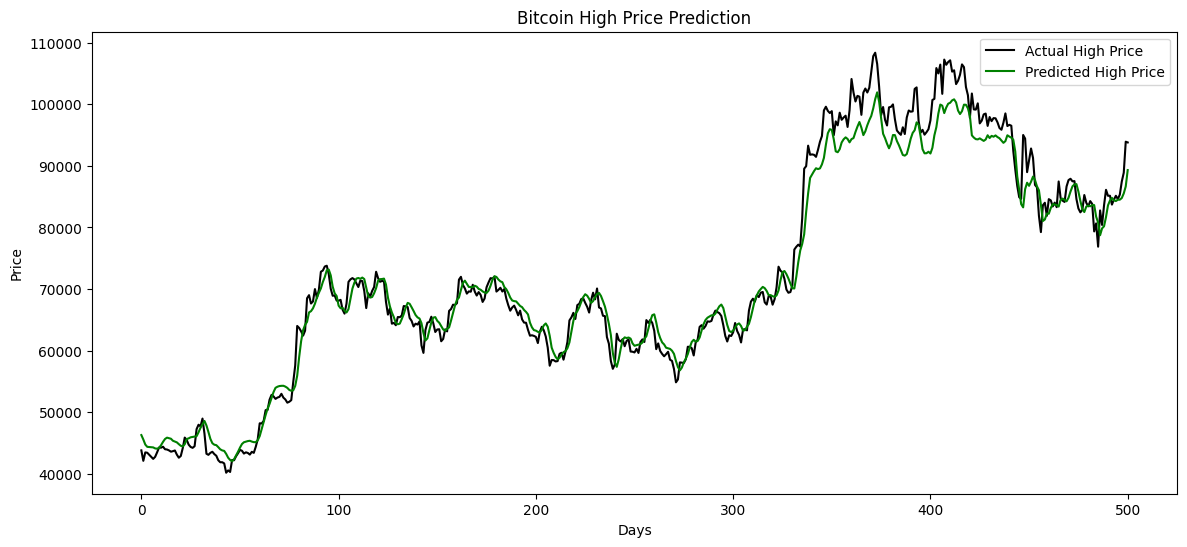

In [26]:
plt.figure(figsize=(14,6))
plt.plot(actual_high, color='black', label='Actual High Price')
plt.plot(predicted_high, color='green', label='Predicted High Price')
plt.title('Bitcoin High Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


In [27]:
# import itertools
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_absolute_error
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dropout, Dense
# import numpy as np
# import pandas as pd
# from tqdm import tqdm

# # Full feature set
# all_features = [
#     # "Open", "High", "Low", "Close", "Volume", "fear_greed", "Number of trades",
#     # "SMA_7", "SMA_21", "RSI_14", "MACD", "Signal_line"
#     'Open', 'High', 'Low', 'Volume', 'SMA_21'
# ]

# sequence_length = 30
# best_mae = float('inf')
# best_features = []
# results = []

# # Brute-force loop
# for subset_size in range(4, 9):  # Try 4 to 8 feature combinations
#     for subset in tqdm(list(itertools.combinations(all_features, subset_size))):
#         try:
#             data = df[list(subset)].copy()
#             target_col = "High"
#             if target_col not in subset:
#                 continue

#             split_idx = int(len(data) * 0.8)
#             train_data = data.iloc[:split_idx]
#             test_data = data.iloc[split_idx:]

#             scaler = MinMaxScaler()
#             train_scaled = scaler.fit_transform(train_data)
#             test_scaled = scaler.transform(test_data)
#             target_idx = list(subset).index(target_col)

#             def build_seq(scaled):
#                 X, y = [], []
#                 for i in range(sequence_length, len(scaled)):
#                     X.append(scaled[i-sequence_length:i])
#                     y.append(scaled[i, target_idx])
#                 return np.array(X), np.array(y)

#             X_train, y_train = build_seq(train_scaled)
#             X_test, y_test = build_seq(test_scaled)

#             # Quick LSTM
#             model = Sequential([
#                 LSTM(32, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
#                 Dropout(0.2),
#                 Dense(1)
#             ])
#             model.compile(optimizer="adam", loss="mae")
#             model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

#             preds = model.predict(X_test)
#             high_mean = scaler.data_min_[target_idx]
#             high_range = scaler.data_max_[target_idx] - scaler.data_min_[target_idx]
#             preds = preds * high_range + high_mean
#             y_true = y_test * high_range + high_mean

#             mae = mean_absolute_error(y_true, preds)
#             results.append((subset, mae))

#             if mae < best_mae:
#                 best_mae = mae
#                 best_features = subset
#                 print(f"🔥 New Best MAE: ${mae:.2f} using {subset}")

#         except Exception as e:
#             print(f"⚠️ Skipped {subset}: {e}")
#             continue

# # Final output
# print(f"\n✅ Best feature set: {best_features}")
# print(f"📏 Best MAE: ${best_mae:.2f}")
